# Data Extraction

## Parsing Y- axis Ticks and Y- vals 
This code parses the x and y axes (horizontal and vertical axes) detection for the y-ticks, calculates the ratio to normalize the figure contents, specifically the bar plots with respect to the y-ticks and finally connects the evaluated y-values with their correspinding legends using clustering algorithm. 
* Note that all the figures recorded have their respective dois as a unique key of identification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 4.2 MB/s 


In [3]:
! pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 4.3 MB/s 
     |████████████████████████████████| 9.9 MB 38.2 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 140 kB 62.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


In [4]:
import cv2, imutils, re, sys, math
import xlsxwriter, json, os, textwrap
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
from pathlib import Path
from matplotlib import rcParams
import boto3

In [5]:
#if os.path.exists(r'/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data'):
#  pass
#else:
#  os.makedirs(r'/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data')
#loc = r'/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data'
#for i in os.listdir(r"/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data"):
#  os.remove(os.path.join(loc,i))

# **AWS**

In [6]:
# Directory of images to run the code on
img_dir = r'/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data'

In [7]:
def expand(points, margin = 1):
    return np.array([
        [[points[0][0][0] - margin, points[0][0][1] - margin]],
        [[points[1][0][0] + margin, points[1][0][1] - margin]],
        [[points[2][0][0] + margin, points[2][0][1] + margin]],
        [[points[3][0][0] - margin, points[3][0][1] + margin]]])

In [8]:
def detectText(path, image, image_text, img_text):
    
    img_height, img_width, channels = image.shape
    _, im_buf = cv2.imencode("." + path.name.split(".")[-1], image)
        
    response = client.detect_text(  #detecting text
        Image = {
            "Bytes" : im_buf.tobytes()
        }
    )
    
    if path.name not in image_text:
        image_text[path.name] = {}
        image_text[path.name]['TextDetections'] = response['TextDetections'] # saving responses
    else:
        image_text[path.name]['TextDetections'].extend(response['TextDetections'])
        
    textDetections = response['TextDetections']
        
    if path.name not in img_text:
        img_text[path.name] = []
            
    for text in textDetections:
        if text['Type'] == 'WORD' and text['Confidence'] >= 80:  #considering more than 80% accuracy parts
                
            vertices = [[vertex['X'] * img_width, vertex['Y'] * img_height] for vertex in text['Geometry']['Polygon']]
            vertices = np.array(vertices, np.int32)
            vertices = vertices.reshape((-1, 1, 2))
            
            image = cv2.fillPoly(image, [expand(vertices)], (255, 255, 255))
                  
            left = np.amin(vertices, axis=0)[0][0]
            top = np.amin(vertices, axis=0)[0][1]
            right = np.amax(vertices, axis=0)[0][0]
            bottom = np.amax(vertices, axis=0)[0][1]
            
            img_text[path.name].append(
                (
                    text['DetectedText'],
                    (
                        int(left),
                        int(top),
                        int(right - left),
                        int(bottom - top)
                    )
                )
            )

    return image

In [9]:
img_text = {}
image_text = {}
client = boto3.client('rekognition', 
                      aws_access_key_id = '-----------', 
                      aws_secret_access_key = '-----------', 
                      region_name="eu-west-1")

for index, path in enumerate(Path(img_dir).iterdir()):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):       
        filepath = img_dir + "/" + path.name
        print(filepath)
        print("[{0}] file name: {1}".format(index, path.name))
        
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        image = detectText(path, image, image_text, img_text)
        detectText(path, image, image_text, img_text)
        
with open('/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/aws-rekognition-output.json', 'w') as out:
    json.dump(image_text, out)
    
with open('/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/ocr-image-text.json', 'w') as out:
    json.dump(img_text, out)

/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/8.sphx_glr_barchart_001.png
[0] file name: 8.sphx_glr_barchart_001.png


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Using json to parse the captions and dois for each image

In [11]:
#with open('/content/drive/MyDrive/Colab Notebooks/Chart Classification/My offline dataset/code/files2/doi_data.json') as doihandler:
#    doidata = json.load(doihandler)

In [12]:
with open('/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/ocr-image-text.json') as ocrhandler:
    images_text = json.load(ocrhandler)

In [13]:
with open('/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/aws-rekognition-output.json') as awshandler:
    bbox_text = json.load(awshandler)

### Function to detect x-axis and y-axis for a plot

In [14]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [15]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            break
            
        start_idx += 1
           
    yaxis = (maxindex, 0, maxindex, height)
    
    if debug:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image)

        ax[1].plot(maxConsecutiveOnes, color = 'k')
        ax[1].axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        ax[1].axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        ax[1].vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            
        start_idx += 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis

In [16]:
def cleanText(image_text):
    
    return [(text, (textx, texty, w, h)) for text, (textx, texty, w, h) in image_text if text.strip() != 'I']

In [17]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    y_text_list = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    image_text = cleanText(image_text)
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            
            numbers = re.findall(r'^[+-]?\d+(?:\.\d+)?[%-]?$', text)
            if bool(numbers):
                y_labels.append((text, (textx, texty, w, h)))
            else:
                y_text_list.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
            # Consider non-numeric only for legends
            legends.append((text, (textx, texty, w, h)))
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    y_labels_list = maxList.copy()
    
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    x_labels_list = maxList.copy()
    
    x_text = x_labels.copy()
    x_labels = []
    hmax = 0
    
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        if texty + h > hmax:
            hmax = texty + h
    
    # Get possible x-text by moving from where we
    # left off in x-labels to the complete
    # height of the image.
    maxIntersection = 0
    maxList = []
    for i in range(hmax + 1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_text):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_text[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    x_text = []
    for text, (textx, texty, w, h) in maxList:
        x_text.append(text)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    
    legends_and_numbers = mergeTextBoxes(legends)
    
    legends = []
    for text, (textx, texty, w, h) in legends_and_numbers:
        if not re.search(r'^([(+-]*?(\d+)?(?:\.\d+)*?[-%) ]*?)*$', text):
            legends.append((text, (textx, texty, w, h)))
    
    
    def canMerge(group, candidate):
        candText, candRect = candidate
        candx, candy, candw, candh = candRect
        
        for memText, memRect in group:
            memx, memy, memw, memh = memRect
                
            if abs(candy - memy) <= 5 and abs(candy + candh - memy - memh) <= 5:
                return True
            elif abs(candx - memx) <= 5:
                return True
                
        return False
    
    # Grouping Algorithm
    legend_groups = []
    for index, (text, rect) in enumerate(legends):
        #print("text: {0}, rect: {1}\n".format(text, rect))
        
        for groupid, group in enumerate(legend_groups):
            if canMerge(group, (text, rect)):
                group.append((text, rect))
                break
        else:
            legend_groups.append([(text, rect)])
    
    #print(legend_groups)
    #print("\n\n")
    
    maxList = []
    
    if len(legend_groups) > 0:
        maxList = max(legend_groups, key = len)

    legends = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
        
    return image, x_labels, x_labels_list, x_text, y_labels, y_labels_list, y_text_list, legends, maxList

In [18]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

## Getting the Ratio for y-value matching 

Similar to the label detection logic, y-ticks are detected: 

Y-ticks 

*  Check only the numerical boxes which are to the left of y-axis and to the top of x-axis.
*  Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the maximum number of numerical boxes.
* The numerical boxes are then used as bounding boxes for calculating the y-ticks.

Ratio:
* Difference between the y-ticks is then calculated.  
* Only consider the mean difference between the y-ticks, rejecting the outliers from the calculated values.
* Finally, the value-tick ratio to normalize the heights of the bounding boxes is calculated by:  

$$
ratio  = \frac{\Delta ticks_{average} }{y\;ticks_{average}}
$$


In [19]:
def getRatio(path, xaxis, yaxis):
    list_text = []
    list_ticks = []
    
    filepath = img_dir + "/" + path.name
    
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape

    image_text = images_text[path.name]
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
        
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            
            # Consider numeric only for ticks on y-axis
            numbers = re.findall(r'\d+(?:\.\d+)?', text)
            if bool(numbers):
                list_text.append((numbers[0], (textx, texty, w, h)))
                          
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(list_text):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(list_text[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    # Get list of text and ticks
    list_text = []
    for text, (textx, texty, w, h) in maxList:
        list_text.append(float(text))
        list_ticks.append(float(texty + h))
        
    text_sorted = (sorted(list_text))
    ticks_sorted  = (sorted(list_ticks))
    
    ticks_diff = ([ticks_sorted[i] - ticks_sorted[i-1] for i in range(1, len(ticks_sorted))])
    text_diff = ([text_sorted[i] - text_sorted[i-1] for i in range(1, len(text_sorted))])
    print("[get text-to-tick ratio] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    # Detected text may not be perfect! Remove the outliers.
    ticks_diff = reject_outliers(np.array(ticks_diff), m=1)
    text_diff = reject_outliers(np.array(text_diff), m=1)
    print("[reject_outliers] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    normalize_ratio = np.array(text_diff).mean() / np.array(ticks_diff).mean()

    return text_sorted, normalize_ratio

In [20]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [21]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) <= m * np.std(data)]

## Writing to Excel workbook

In [22]:
def addToExcel(dataname, data, row):
    col = 0

    worksheet.write(row, col, dataname)
    for content in data:
        col += 1
        worksheet.write(row, col, content)

## Matching the ratio for final data extraction 

Y-val data:
    - The height of each bounding box is recorded by the help of the merging rectangles during Cluster count 
    estimation method.
    - Eventually, we used the ratio to calculate the y-values as:

$$
y_{values}  =  ratio \times height_{bounding\;box}
$$


In [23]:
def mergeRects(contours, mode='contours'):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        if mode == 'contours':
            rects.append(cv2.boundingRect(cnt))
        elif mode == 'rects':
            rects.append(cnt)
        
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])
    
    return acceptedRects

In [24]:
def mergeTextBoxes(textboxes):
    rects = []
    rectsUsed = []
    
    # Just initialize bounding rects and set all bools to false
    for box in textboxes:
        rects.append(box)
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[1][0]
    
    def getYFromRect(item):
        return item[1][1]

    rects.sort(key = lambda x: (getYFromRect, getXFromRect))
    
    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 10
    yThr = 0

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[1][0]
            currxMax = supVal[1][0] + supVal[1][2]
            curryMin = supVal[1][1]
            curryMax = supVal[1][1] + supVal[1][3]
            currText = supVal[0]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[1][0]
                candxMax = subVal[1][0] + subVal[1][2]
                candyMin = subVal[1][1]
                candyMax = subVal[1][1] + subVal[1][3]
                candText = subVal[0]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)
                    currText = currText + ' ' + candText
                    
                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currText, (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin)])
    
    return acceptedRects

In [25]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [26]:
def euclidean(v1, v2):
    return sum((p - q) ** 2 for p, q in zip(v1, v2)) ** .5

def angle_between(p1, p2):
    
    deltaX = p1[0] - p2[0]
    deltaY = p1[1] - p2[1]

    return math.atan2(deltaY, deltaX) / math.pi * 180
    
def RectDist(rectA, rectB):
    (rectAx, rectAy, rectAw, rectAh) = rectA
    (rectBx, rectBy, rectBw, rectBh) = rectB
    
    return abs(rectAx + rectAx / 2 - rectBx - rectBx / 2)

In [27]:
def getProbableYLabels(image, contours, xaxis, yaxis):
    y_labels = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, rect in enumerate(contours):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(contours[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
                    
    return image, maxList

In [28]:
def expand(points, margin):
    return np.array([
        [[points[0][0][0] - margin, points[0][0][1] - margin]],
        [[points[1][0][0] + margin, points[1][0][1] - margin]],
        [[points[2][0][0] + margin, points[2][0][1] + margin]],
        [[points[3][0][0] - margin, points[3][0][1] + margin]]])

## Saving y-values in our data excel sheet 

In [29]:
images = []
texts = []

def getYVal(img_dir):
    yValueDict = {}
    for index, path in enumerate(Path(img_dir).iterdir()):
        if path.name.endswith('.png') or path.name.endswith('.jpg'):
            filepath = img_dir + "/" + path.name
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_height, img_width, _ = img.shape
            
            # Axes detection
            xaxis, yaxis = detectAxes(filepath)
            
            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)

            image_text = images_text[path.name]
            img, x_labels, x_labels_list, _, _, _, _, legends, legendBoxes = getProbableLabels(img, image_text, xaxis, yaxis)
            actual_image = img.copy()
            
            try:
                list_text, normalize_ratio = getRatio(path, xaxis, yaxis)
                print("[getYVal] legends: {0}".format(legends))
                print("[{0}] path: {1}, ratio: {2}".format(index, path.name, normalize_ratio), end='\n\n')
            
                texts = bbox_text[path.name]['TextDetections']
                
                for text in texts:
                    if text['Type'] == 'WORD' and text['Confidence'] >= 80:
                        vertices = [[vertex['X'] * img_width, vertex['Y'] * img_height] for vertex in text['Geometry']['Polygon']]
                        vertices = np.array(vertices, np.int32)
                        vertices = vertices.reshape((-1, 1, 2))

                        img = cv2.fillPoly(img, [expand(vertices, 1)], (255, 255, 255))

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                threshold = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]
                
                contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contours = [contour for contour in contours if cv2.contourArea(contour) < 0.01 * img_height * img_width]

                contours = [cv2.approxPolyDP(contour, 3, True) for contour in contours]
                rects = [cv2.boundingRect(contour) for contour in contours]

                groups = []
                legendtexts = []
                legendrects = []
    
                for box in legendBoxes:
                    text, (textx, texty, width, height) = box
                    bboxes = filterBbox(rects, box)
                    
                    if bboxes is not None:
                        for rect in [bboxes]:
                            (x, y, w, h) = rect
                            legendrects.append(rect)
                            
                            group = boxGroup(actual_image, rect)[0]
                            group = [arr.tolist() for arr in group]
                            
                            groups.append(group)
                            legendtexts.append(text)
                            
                            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

                        cv2.rectangle(img, (textx, texty), (textx + width, texty + height), (255, 0, 0), 2)
                                 
                data = {}
                for legend in legends:
                    data[legend] = {}
                    
                    for x_label, box in x_labels_list:
                        data[legend][x_label] = 0.0
                        
                for i in range(len(groups)):

                    img = cv2.imread(img_dir + "/" + path.name)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    legendtext = legendtexts[i]
                    
                    for box in legendrects:
                        (textx, texty, width, height) = box
                        cv2.rectangle(img, (textx, texty), (textx + width, texty + height), (255, 255, 255), cv2.FILLED)
                    
                    mask = None
                    for value in groups[i]:
                        COLOR_MIN = np.array([value[0], value[1], value[2]], np.uint8)
                        COLOR_MAX = np.array([value[0], value[1], value[2]], np.uint8)

                        if mask is None:
                            mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX)
                        else:
                            mask = mask | cv2.inRange(img, COLOR_MIN, COLOR_MAX)

                    image = cv2.bitwise_and(img, img, mask = mask)
                    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, (3, 3))

                    edged = cv2.Canny(image, 0, 250)
                    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    contours = [contour for contour in contours if cv2.contourArea(contour) > 0.]

                    # Remove noisy ones!
                    if len(contours) == 0 or len(contours) > 100:
                        continue

                    contours = [cv2.approxPolyDP(contour, 3, True) for contour in contours]

                    rects = mergeRects(contours)
                    textBoxes = []
                    labels = []
                    
                    for rectBox in rects:
                        min_distance = sys.maxsize
                        closestBox = None
                        labeltext = None

                        for text, textBox in x_labels_list:
                            if RectDist(rectBox, textBox) < min_distance:
                                closestBox = textBox
                                min_distance = RectDist(rectBox, textBox)
                                labeltext = text

                        textBoxes.append(closestBox)
                        labels.append(labeltext)
                        
                    list_len = []
                    
                    for rect in rects:
                        list_len.append((rect, float(rect[3])))

                    # y-values will be a product of the normalize ratio and each length              
                    y_val = [(rect, round(l* normalize_ratio, 1)) for rect, l in list_len]
                    
                    for x_label, box in x_labels_list:
                        (x, y, w, h) = box
                        value = 0.0
                        closest = None
                        dist = sys.maxsize
                        
                        for index, item in enumerate(y_val):
                            if labels[index] == x_label:
                                (vx, vy, vw, vh) = item[0]
                                if abs(x + w/2 - vx - vw/2) < dist:
                                    dist = abs(x + w/2 - vx - vw/2)
                                    closest = item[0]
                                    value = item[1]
                             
                        data[legendtext][x_label] = value
                     
                yValueDict[path.name] = data
            
            except Exception as e:
                print(e)
                continue
                
    return yValueDict

In [30]:
def filterBbox(rects, legendBox):
    text, (textx, texty, width, height) = legendBox
    
    filtered = []
    for rect in rects:
        (x, y, w, h) = rect
        if abs(y - texty) <= 10 and abs(y - texty + h - height) <= 10:
            filtered.append(rect)

    filtered = mergeRects(filtered, 'rects')
    
    closest = None
    dist = sys.maxsize
    for rect in filtered:
        (x, y, w, h) = rect
        if abs(x + w - textx) <= dist:
            dist = abs(x + w - textx)
            closest = rect
    
    return closest

In [31]:
def boxGroup(img, box):
    (x, y, w, h) = box

    image = img[y:y+h, x:x+w].reshape((h * w, 3))
    values, counts = np.unique(image, axis = 0, return_counts = True)

    # Remove white and near-by pixels
    threshold = 5
    for r in range(255 - threshold, 256):
        for g in range(255 - threshold, 256):
            for b in range(255 - threshold, 256):
                image = image[np.where((image != [r, g, b]).any(axis = 1))]

    values, counts = np.unique(image, axis = 0, return_counts = True)
                
    sort_indices = np.argsort(-counts)
    values, counts = values[sort_indices], counts[sort_indices]

    groups = []
    groupcounts = []

    for idx, value in enumerate(values):
        grouped = False

        for groupid, group in enumerate(groups):
            for member in group:
                r, g, b = member
                vr, vg, vb = value

                if (abs(vr.astype(np.int16) - r.astype(np.int16)) <= 5 and
                    abs(vg.astype(np.int16) - g.astype(np.int16)) <= 5 and
                    abs(vb.astype(np.int16) - b.astype(np.int16)) <= 5):
                        group.append(value)
                        groupcounts[groupid] += counts[idx]
                        grouped = True
                        break

            if grouped:
                break

        if not grouped:
            groups.append([value])
            groupcounts.append(counts[idx])

    groupcounts = np.array(groupcounts)
    sort_indices = np.argsort(-groupcounts)
    new_groups = [groups[i] for i in sort_indices]
    groups = new_groups
    
    return groups

In [32]:
yValueDict = getYVal(img_dir)

[get text-to-tick ratio] ticks_diff: [55.0, 56.0, 54.0, 55.0, 56.0, 54.0, 56.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [55. 55.], text_diff: [5. 5. 5. 5. 5. 5. 5.]
[getYVal] legends: ['Men', 'Women']
[0] path: 8.sphx_glr_barchart_001.png, ratio: 0.09090909090909091



In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
img_size = 224

model = load_model(r"/content/drive/MyDrive/Chart Classification/model_inception2.h5")
labels = ['AreaGraph', 'BarGraph', 'BoxPlot', 'BubbleChart', 'FlowChart', 'LineGraph', 'Map',         
        'NetworkDiagram', 'ParetoChart', 'PieChart','ScatterGraph', 'TreeDiagram', 'VennDiagram']
image = cv2.imread(filepath)
image0 = cv2.resize(image, (224,224))
image = image0/255.0
image = image.reshape(-1, img_size, img_size, 3)
predict = model.predict(image)
predict = list(predict[0])
predict_name = labels[predict.index(max(predict))]
print("This is %s graph."%predict_name)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1/1 [==============================] - 4s 4s/step
This is BarGraph graph.


Given input is BarGraph image. 




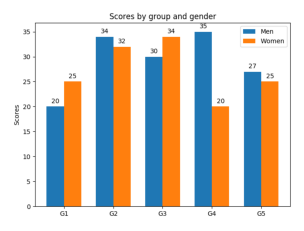

This is BarGraph type image. In this graph maxima for Men is 34.90, minima is
20.00 and average is 29.12. for Women maxima is 33.90, minima is 20.00 and
average is 27.16. 


file name    :   8.sphx_glr_barchart_001.png
x-text       :   []
x-labels     :   ['G1', 'G2', 'G3', 'G4', 'G5']
y-text       :   ['Scores']
y-labels     :   ['35', '30', '25', '20', '15', '10', '5', '0']
legends      :   ['Men', 'Women']
data         :   {'Men': {'G1': 20.0, 'G2': 33.9, 'G3': 29.9, 'G4': 34.9, 'G5': 26.9}, 'Women': {'G1': 25.0, 'G2': 31.9, 'G3': 33.9, 'G4': 20.0, 'G5': 25.0}}


In [34]:
workbook = xlsxwriter.Workbook('/content/drive/MyDrive/Colab Notebooks/Chart Classification/Generated_Data/FigureData2.xlsx', {'nan_inf_to_errors': True})

for index, path in enumerate(Path(img_dir).iterdir()):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):
        if path.name in yValueDict:
            filepath = img_dir + "/" + path.name
            
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            height, width, channels = image.shape
            xaxis, yaxis = detectAxes(filepath)
            y_text = []

            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)
                
            image_text = images_text[path.name]
            image, x_labels, _, x_text, y_labels, y_labels_list, y_text_list, legends, _ = getProbableLabels(image,
                                                                                                  image_text,
                                                                                                  xaxis,
                                                                                                  yaxis)
            
            # Sort bounding rects by y coordinate
            def getYFromRect(item):
                return item[1][1]

            y_labels_list.sort(key = getYFromRect)
            y_text_list.sort(key = getYFromRect, reverse=True)
            
            for text, (textx, texty, w, h) in y_text_list:
                y_text.append(text)

            # Append doi values for each image.
            pdfname = '-'.join(path.name.split('-')[:-2]) + '.pdf'
            
            #if pdfname in doidata['Doi']:
            #    doi = doidata['Doi'][pdfname]
            #else:
            #    doi = ''
             
            # Write to Excel
            worksheet = workbook.add_worksheet()            
            
            addToExcel("file name", [path.name], 1)
            addToExcel("x-text", x_text, 2)
            addToExcel("x-labels", x_labels, 3)
            addToExcel("y-text", y_text, 4)
            addToExcel("y-labels", y_labels, 5)
            addToExcel("legends", legends, 6)
            
            data = yValueDict[path.name]

            if predict_name=='BarGraph':

              if len(data)==0:
                data = "Not Detected"
              else:
                data = data
                column = 9
                for legend, datadict in data.items():
                    if column == 9:
                        addToExcel("", datadict.keys(), 8)    
                        
                    addToExcel(legend, datadict.values(), column)
                    column += 1

                x = 0
                sent = []
                for i in data.keys():
                      
                    if x==0:
                      s = ("This is %s type image. In this graph maxima for %s is %.2f, minima is %.2f and average is %.2f."%(predict_name,i, max(data.get(i).values()), min(data.get(i).values()),mean(data.get(i).values())))
                      sent.append(s)
                      x+=1
                    else:
                      s = ("for %s maxima is %.2f, minima is %.2f and average is %.2f."%(i, max(data.get(i).values()), min(data.get(i).values()),mean(data.get(i).values())))
                      sent.append(s)
              
            
              print("Given input is %s image."%predict_name, "\n\n")

              img = plt.imread(filepath)
              plt.imshow(img)
              plt.axis('off')
              plt.show()
              print(textwrap.fill(" ".join(sent), width=80), "\n\n")
                  
              # Print the output here!
              print("file name    :  ", path.name)

              print("x-text       :  ", x_text)
              print("x-labels     :  ", x_labels)
              print("y-text       :  ", y_text)
              print("y-labels     :  ", y_labels)
              print("legends      :  ", legends)
              print("data         :  ", data)
            
            elif predict_name=='PieChart':

              if len(data)==0:
                data = "Not Detected"
              else:
                data = data
                column = 9
                for legend, datadict in data.items():
                    if column == 9:
                        addToExcel("", datadict.keys(), 8)    
                        
                    addToExcel(legend, datadict.values(), column)
                    column += 1

                x = 0
                sent = []
                           
              print("Given input is %s image."%predict_name, "\n\n")
                                      
              # Print the output here!
              print("file name    :  ", path.name)

              img = plt.imread(filepath)
              plt.imshow(img)
              plt.axis('off')
              plt.show()

              sent = []
              sent.append("This is %s type image."%(predict_name))
              sent.append("Labels in this graph are %s %s %s %s %s."%(", ".join(x_text), ", ".join(y_text), ", ".join(x_labels), ", ".join(y_labels), ", ".join(legends)))
              print(textwrap.fill(" ".join(sent), width=80), "\n\n")


            else:

              if len(data)==0:
                data = "Not Detected"
              else:
                data = data
                column = 9
                for legend, datadict in data.items():
                    if column == 9:
                        addToExcel("", datadict.keys(), 8)    
                        
                    addToExcel(legend, datadict.values(), column)
                    column += 1

                x = 0
                sent = []
                           
              print("Given input is %s image."%predict_name, "\n\n")
                                      
              # Print the output here!
              print("file name    :  ", path.name)

              print("x-text       :  ", x_text)
              print("x-labels     :  ", x_labels)
              print("y-text       :  ", y_text)
              print("y-labels     :  ", y_labels)
              print("legends      :  ", legends)
              print("data         :  ", data)

              img = plt.imread(filepath)
              plt.imshow(img)
              plt.axis('off')
              plt.show()

              sent = []
              sent.append("This is %s type image."%(predict_name))
              if len(x_text)==0: 
                sent.append("x-axis text is NOT DETECTED.")
              else:
                sent.append("Here x-axis text is %s."%(", ".join(x_text)))
              
              if len(x_labels)==0:
                sent.append("x-axis labesl are NOT DETECTED.")
              else:
                sent.append("x-axis labels are %s."%(", ".join(x_labels)))
              if len(y_text)==0: 
                sent.append("y-axis text is NOT DETECTED.")
              else:
                sent.append("y-axis text is %s."%(", ".join(y_text)))
              if len(y_labels)==0: 
                sent.append("y-axis labels are NOT DETECTED.")
              else:
                sent.append("y-axis labels are %s."%(", ".join(y_labels)))
              if len(legends)==0: 
                sent.append("legends are NOT DETECTED.")
              else:
                sent.append("legends are %s"%(", ".join(legends)))
              #sent.append("That's all about this given graph!")
              
              #print(len(x_text))
              print(textwrap.fill(" ".join(sent), width=80), "\n\n")

            # Insert the image
            worksheet.insert_image('J21', filepath)

# Close the excel workbook!
workbook.close()